# Thresholding

In [2]:
import tensorflow as tf
import numpy as np
from typing import List
import pickle

In [3]:
from grid import *

In [5]:
filler_filepath = "../03-psychophysics/data/training-hole-filling/training-encoders/2019-07-18_13-57_encoder_48_48.h5"
filler = tf.keras.models.load_model(filler_filepath)

W0802 12:05:28.379828  3836 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [6]:
encoder_filepath = "./data/training-intermediate-data/training-encoders/2019-08-01_11-20_encoder_PolarGrid_10-10_48-48-half-random.h5"
encoder = tf.keras.models.load_model(encoder_filepath)

W0802 12:05:29.926314  3836 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [7]:
grid_filepath = "./data/training-intermediate-data/training-grids/2019-08-01_11-20_grid_PolarGrid_10-10_48-48-half-random.pkl"

with open(grid_filepath, 'rb') as infile:
    grid = pickle.load(infile)

In [8]:
def difference(rendered: np.ndarray, filled: np.ndarray) -> float:
    """
    Given the rendered and filled image, return the sum of squared pixel-wise difference.
    """
    
    return np.sum((rendered - filled) ** 2) 

In [9]:
def binarise(encoding: np.ndarray, threshold: float) -> np.ndarray:
    """
    Binarises an encoding at a given threshold. 
    """
    return np.where(encoding > threshold, 1.0, 0.0).astype(np.float32)

In [10]:
def iterate_diffs(encoding: np.ndarray, grid: AbstractGrid) -> List[float]:
    """
    Given an encoding and grid, iterates through 100 thresholds between 0 and 1 at 0.01 intervals. 
    """
    
    original = render_tensor(grid, encoding)
    filled = filler(tf.expand_dims(original, 0))
    
    diffs = []
    
    for threshold in np.linspace(0, 0.99, 100):
        binarised = binarise(encoding, threshold)
        rendered = render_tensor(grid, binarised)
        diff = difference(rendered, filled)
        diffs.append(diff)
        
    return diffs

In [24]:
def find_best_thresholds(encoder: tf.keras.Model, grid: AbstractGrid, seed: tf.Tensor) -> List[float]:
    """
    Given an encoder and a grid, find the best threshold for each digit for a given seed.
    """
    
    best_thresholds = []
    best_threshold_diffs = []
    
    digits = np.array(list(range(10)))
    seeds = tf.squeeze(np.array([seed for i in range(10)]))
    
    encodings = encoder((seeds, digits), training=False)
    
    for encoding in encodings:
        diffs = iterate_diffs(encoding, grid)
        lowest_diff = np.argmin(diffs)
        best_threshold = 0.01 * lowest_diff
        
        best_threshold_diffs.append(lowest_diff)
        best_thresholds.append(best_threshold)
        
    return best_thresholds, best_threshold_diffs

def render_and_process(encoder: tf.keras.Model, seed: tf.Tensor, best_thresholds: List[float]) -> np.ndarray:
    """
    Renders and post-processes all 10 digits and returns them. 
    """
    
    digits = np.array(list(range(10)))
    seeds = tf.squeeze(np.array([seed for i in range(10)]))
    
    encodings = encoder((seeds, digits))
    
    binarised = [binarise(encodings[digit], best_thresholds[digit]) for digit in range(10)]
    rendered = list(map(lambda x: render_tensor(grid, x), binarised))
    
    return rendered

# Running

In [13]:
SEED_SIZE = 32
seed = tf.random.uniform((1, SEED_SIZE))

In [25]:
best_thresholds, best_threshold_diffs = find_best_thresholds(encoder, grid, seed)

In [26]:
best_thresholds

[0.25, 0.18, 0.16, 0.18, 0.17, 0.23, 0.15, 0.17, 0.4, 0.31]

In [27]:
best_threshold_diffs

[25, 18, 16, 18, 17, 23, 15, 17, 40, 31]

In [28]:
from matplotlib import pyplot as plt

In [29]:
digit_renders = render_and_process(encoder, seed, best_thresholds)

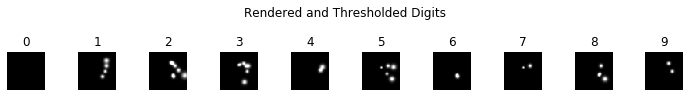

In [30]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for digit in range(10):
    axes[digit].imshow(digit_renders[digit], cmap='gray')
    axes[digit].set_title("{}".format(digit))
    axes[digit].axis('off')
    
plt.suptitle("Rendered and Thresholded Digits", y=1.3)
plt.tight_layout()

In [31]:
no_postprocess_encodings = encoder((tf.random.uniform((10, SEED_SIZE)), np.array([i for i in range(10)])))
no_postprocess_renders = tf.map_fn(lambda x: render(grid, x.numpy()), no_postprocess_encodings)

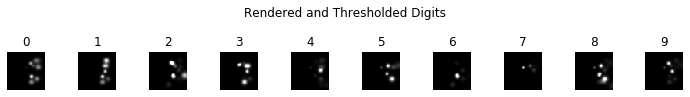

In [52]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for digit in range(10):
    axes[digit].imshow(no_postprocess_renders[digit], cmap='gray')
    axes[digit].set_title("{}".format(digit))
    axes[digit].axis('off')
    
plt.suptitle("Rendered and Thresholded Digits", y=1.3)
plt.tight_layout()

In [32]:
# For digit 

digits = np.array(list(range(10)))
seeds = tf.squeeze(np.array([seed for i in range(10)]))
encodings = encoder((seeds, digits))

Text(0.5, 1.3, 'Difference between Renders and Hole-Filled by Binarisation Threshold')

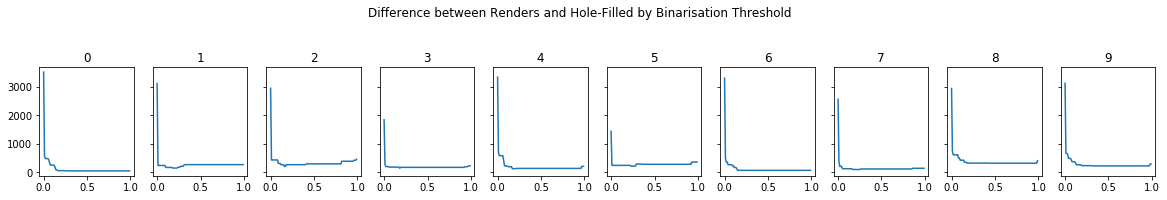

In [44]:
fig, ax = plt.subplots(1, 10, figsize=(20,2), sharex=True, sharey=True)

for test_digit in range(10):
    diffs = iterate_diffs(encodings[test_digit], grid)
    ax[test_digit].plot(np.linspace(0, 0.99, 100), diffs)
    ax[test_digit].set_title(test_digit)
    
#plt.ylabel("Sum squared pixel-wise difference")
#plt.xlabel("Encoding binarisation threshold")
plt.suptitle("Difference between Renders and Hole-Filled by Binarisation Threshold", y=1.3)

In [47]:
from functools import partial

In [50]:
filled_examples = filler(tf.map_fn(partial(render_tensor, grid), encodings))

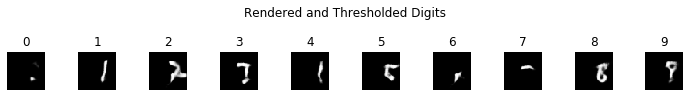

In [51]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for digit in range(10):
    axes[digit].imshow(filled_examples[digit], cmap='gray')
    axes[digit].set_title("{}".format(digit))
    axes[digit].axis('off')
    
plt.suptitle("Rendered and Thresholded Digits", y=1.3)
plt.tight_layout()